# Sample prep from covid19clinic

In [3]:
# v 0.1 : Adaptation by B. MAUBERT . Import our own definition of KF deepwell.
# J'ai décidé d'adapter ce script avec mes fonctions gérant notre ordre de travail.
# v 0.2 : avancées diverses 
# v 0.3 : BUT mettre en place la fonction de distribution du £
# v 0.4 : Adaptation pour la simulation
# v 0.5 : Distribuer le réactif depuis un tube conique ; 
# v 0.6 : function to calculate the height of pipetting in a conical bottom vial; This function use a model and 
# result is corrected with measured data

In [4]:
import math
import opentrons

from opentrons.types import Point
from opentrons import protocol_api
import time
import os
from timeit import default_timer as timer
import json
from datetime import datetime
import csv
import json

# To use Jupyter-notebook, we add theses lines 

In [5]:
import opentrons.execute
from opentrons import protocol_api
from opentrons import simulate

# Direct access to OT-2 or simulation ?

In [6]:
simulation = True

# Improve the protocol class
In a simulation mode, you see the result this way 
so we are gooing to add a methode to ctx (an isntance of the opentrons.protocol_api.protocol_context.ProtocolContext class. you cas do it as following : 

In [7]:
def print_simulation_result(self,):
    for line in self.commands():
        print(line)

In [8]:
if simulation: 
    ctx = simulate.get_protocol_api('2.9')
    # Surcharger la fonction comment()
    ctx.comment = print
    opentrons.protocol_api.protocol_context.ProtocolContext.messages = print_simulation_result 
else:
    ctx = protocol_api.get_protocol_api('2.9')

/home/bertrand/.opentrons/robot_settings.json not found. Loading defaults
/home/bertrand/.opentrons/deck_calibration.json not found. Loading defaults


In [9]:
from ot_2_functions import *

Now, you can use : 

In [10]:
ctx.messages()

# Starting to move OT-2

In [11]:
ctx.home()

In [12]:
# metadata
metadata = {
    'protocolName': 'S2 Station A Kingfisher Version 2',
    'author': 'Eva González & José Luis Villanueva (jlvillanueva@clinic.cat)',
    'source': 'Hospital Clínic Barcelona',
    'apiLevel': '2.9',  # Original 2.0
    'description': 'Protocol for Kingfisher sample setup (A) - Viral/Pathogen II Kit (ref A48383)'
}

'''
'technician': '$technician',
'date': '$date'
'''

"\n'technician': '$technician',\n'date': '$date'\n"

In [13]:
#Defined variables
##################
NUM_SAMPLES = 80
five_ml_rack = False

air_gap_vol = 50  # 15 

volume_sample = 200    # 400
x_offset = [0, 0] 

# Screwcap variables
diameter_screwcap = 8.25  # Diameter of the screwcap
volume_cone = 50  # Volume in ul that fit in the screwcap cone

# Calculated variables
area_section_screwcap = (math.pi * diameter_screwcap**2) / 4
h_cone = (volume_cone * 3 / area_section_screwcap)
screwcap_cross_section_area = math.pi * diameter_screwcap**2 / 4  # screwcap cross section area

In [14]:
# Define the STEPS of the protocol
STEP = 0
STEPS = {  # Dictionary with STEP activation, description, and times
    1: {'Execute': True, 'description': 'Add samples (200 ul)'},
}

for s in STEPS:  # Create an empty wait_time
    if 'wait_time' not in STEPS[s]:
        STEPS[s]['wait_time'] = 0   

In [15]:
# Creating a log file
if not ctx.is_simulating():
    print("ctx is a real OT-2")
    # Folder and file_path for log time
    folder_path = '/var/lib/jupyter/notebooks'
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    #file_path = folder_path + '/KA_SampleSetup_pathogen_time_log.txt' 
    file_path = folder_path + '/KA_SampleSetup_viral_path2_time_log.txt'
else:
    print("ctx is a simulation : no log")

ctx is a simulation : no log


In [16]:
samples = Reagent(name = 'Samples',
                  flow_rate_aspirate = 1,
                  flow_rate_dispense = 1,
                  rinse = False,
                  delay = 0,
                  reagent_reservoir_volume = 700 * 24,
                  num_wells = 24,  # num_cols comes from available columns
                  h_cono = 4,
                  v_fondo = 4 * math.pi * 4**3 / 3
                  )  # Sphere

samples.vol_well = 700

In [17]:
def move_vol_multichannel(pipet, reagent, source, dest, vol, air_gap_vol, x_offset,
                   pickup_height, rinse, disp_height, blow_out, touch_tip, verbose = False):
    '''
    x_offset: list with two values. x_offset in source and x_offset in destination i.e. [-1,1]
    pickup_height: height from bottom where volume
    rinse: if True it will do 2 rounds of aspirate and dispense before the tranfer
    disp_height: dispense height; by default it's close to the top (z=-2), but in case it is needed it can be lowered
    blow_out, touch_tip: if True they will be done after dispensing
    '''
    def help(msg):
        if verbose: 
            input(msg)
            
    # Rinse before aspirating
    
    if rinse == True:
        custom_mix(pipet, reagent, location = source, vol = vol,
                   rounds = 2, blow_out = True, mix_height = 0,
                   x_offset = x_offset)
    # SOURCE
    s = source.bottom(pickup_height).move(Point(x = x_offset[0]))
    
    pipet.aspirate(vol, s, rate = reagent.flow_rate_aspirate)  # aspirate liquid
    
    help("after aspirate ... suite")
    
    if air_gap_vol != 0:  # If there is air_gap_vol, switch pipette to slow speed
        pipet.aspirate(air_gap_vol, source.top(z = -3),
                       rate = reagent.flow_rate_aspirate)  # air gap
    help("after air_gap ....continuer")
    
    # GO TO DESTINATION
    drop = dest.top(z = disp_height).move(Point(x = x_offset[1]))
    
    print(drop)
    help("after drop : continuer");
    
    pipet.dispense(vol + air_gap_vol, drop,
                   rate = reagent.flow_rate_dispense)  # dispense all
    help("after dispense.... continuer")
    ctx.delay(seconds = reagent.delay) # pause for x seconds depending on reagent
    
    if blow_out == True:
        pipet.blow_out(dest.top(z = -5))
        help("End of blow_out")
        
    if touch_tip == True:
        pipet.touch_tip(radius = 0.9, speed = 20, v_offset = -5)
        help("End of touch tip")

In [18]:
def custom_mix(pipet, reagent, location, vol, rounds, blow_out, mix_height,
x_offset, source_height = 3):
    '''
    Function for mixing a given [vol] in the same [location] a x number of [rounds].
    blow_out: Blow out optional [True, False]
    x_offset = [source, destination]
    source_height: height from bottom to aspirate
    mix_height: height from bottom to dispense
    '''
    if mix_height == 0:
        mix_height = 3
    pipet.aspirate(1, 
                   location=location.bottom(z=source_height).move(Point(x=x_offset[0])), 
                   rate=reagent.flow_rate_aspirate)
    for _ in range(rounds):
        pipet.aspirate(vol, 
                       location=location.bottom(z=source_height).move(Point(x=x_offset[0])),
                       rate=reagent.flow_rate_aspirate)
        
        pipet.dispense(vol, 
                       location=location.bottom(z=mix_height).move(Point(x=x_offset[1])),
                       rate=reagent.flow_rate_dispense)
        
    pipet.dispense(1, 
                   location=location.bottom(z=mix_height).move(Point(x=x_offset[1])), 
                   rate=reagent.flow_rate_dispense)

    if blow_out == True:
        pipet.blow_out(location.top(z=-2))  # Blow out

In [19]:
##########
# pick up tip and if there is none left, prompt user for a new rack
def pick_up(pip):
    #  nonlocal tip_track
    if not ctx.is_simulating():
        if tip_track['counts'][pip] == tip_track['maxes'][pip]:
            ctx.pause('Replace ' + str(pip.max_volume) + 'µl tipracks before \
            resuming.')
            pip.reset_tipracks()
            tip_track['counts'][pip] = 0
    pip.pick_up_tip()

# Load labware and modules

##  Load Sample racks

In [20]:
if NUM_SAMPLES < 96:
    rack_num = math.ceil(NUM_SAMPLES / 24)
    msg = 'Used source racks are ' + str(rack_num)
    ctx.comment(msg)
    print(msg)
    samples_last_rack = NUM_SAMPLES - rack_num * 24
else:
    rack_num = 4

Used source racks are 4
Used source racks are 4


In [21]:
if five_ml_rack == True:
    rack = 'ngny_tuberack_24_5ml'
else:
    #  rack = 'opentrons_24_tuberack_generic_2ml_screwcap'
    rack = 'opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap'

# source_racks = [ctx.load_labware(rack, slot, 'source_tuberack_' + str(i + 1))
#                 for i, slot in enumerate(['4', '1', '5', '2'][:rack_num])
#                 ]

In [22]:
# Sources of binding Lysis
reagent_rack = ctx.load_labware('opentrons_10_tuberack_falcon_4x50ml_6x15ml_conical', 6)
binding_lysis_stock = reagent_rack.wells_by_name()["B4"]

# sources of samples
plate_24_1 = ctx.load_labware('opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap', 4 )
plate_24_2 = ctx.load_labware('opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap', 5 )
plate_24_3 = ctx.load_labware('opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap', 1 )
plate_24_4 = ctx.load_labware('opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap', 2 )

source_racks = [ plate_24_1, plate_24_2, plate_24_3, plate_24_4 ]

In [23]:
source_racks

[Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 4,
 Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 5,
 Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 1,
 Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 2]

## Importing custom labware in Jupyter notebook

In [24]:
with open('cherdeepwellkingfisher_96_wellplate_2000ul.json') as my_dw_P96_file:
    ref_to_my_dw_P96_file = json.load(my_dw_P96_file)

In [25]:
##################################
# Destination plate
dest_plate = ctx.load_labware_from_definition(ref_to_my_dw_P96_file, 3, 'KF 96well destination plate')   # OK

##################################
# Load tip_racks
tips1000 = [ctx.load_labware('opentrons_96_filtertiprack_1000ul', slot, '1000 µl filter tiprack')
            for slot in ['10']]  # Replace by [7, 10, 11] forme example for other tipracks.

# Deck summary

In [26]:
deck_summary(ctx)

| 10: 1000 µl filter tiprack  | 11: ***                     | 12: Trash                   | 
| 7: ***                      | 8: ***                      | 9: ***                      | 
| 4: opentrons_...ck_snapcap  | 5: opentrons_...ck_snapcap  | 6: opentrons_...ml_conical  | 
| 1: opentrons_...ck_snapcap  | 2: opentrons_...ck_snapcap  | 3: KF 96well ...tion plate  | 


In [27]:
################################################################################
# Declare which reagents are in each reservoir as well as deepwell and elution plate

# setup samples and destinations
sample_sources_full = generate_source_table(source_racks)
sample_sources = sample_sources_full[:NUM_SAMPLES]
destinations = dest_plate.wells()[:NUM_SAMPLES]

p1000 = ctx.load_instrument(
    'p1000_single_gen2', 'left', tip_racks=tips1000)  # load P1000 pipette

# used tip counter and set maximum tips available
tip_track = {
    'counts': {p1000: 0},  # p1000: 0},
    'maxes': {p1000: len(tips1000) * 96}  # ,p20: len(tips20)*96,
}

# Distribution of binding solution

In [29]:
nb_tests = 5

In [30]:
ctx.comment("**** Début distribution de binding solution")
p1000.distribute(260, binding_lysis_stock, reverse_order_wells(dest_plate, 8) [:nb_tests], disposal_volume=0, 
                 blowout_location = 'source well') 

**** Début distribution de binding solution


<InstrumentContext: p1000_single_v2.0 in LEFT>

In [31]:
ctx.messages()

Distributing 260.0 from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 to H1 of KF 96well destination plate on 3
Transferring 260.0 from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 to H1 of KF 96well destination plate on 3
Picking up tip from A1 of 1000 µl filter tiprack on 10
Aspirating 780.0 uL from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 at 274.7 uL/sec
Dispensing 260.0 uL into H1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dispensing 260.0 uL into G1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dispensing 260.0 uL into F1 of KF 96well destination plate on 3 at 274.7 uL/sec
Aspirating 520.0 uL from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 at 274.7 uL/sec
Dispensing 260.0 uL into E1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dispensing 260.0 uL into D1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dropping tip into A1 of Opentrons Fixed Trash o

### Ajouter une série à partir d'une solution (compléter une plaque)

In [32]:
def distribute_reagent(volume, source, destination, nb_tests, skip_wells):
    p1000.distribute(volume, source, destination[skip_wells:skip_wells+nb_tests], disposal_volume=0, 
                 blowout_location = 'source well')

In [33]:
distribute_reagent(260, binding_lysis_stock, reverse_order_wells(dest_plate, 8), nb_tests=3, skip_wells=12)

In [34]:
ctx.messages()

Distributing 260.0 from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 to H1 of KF 96well destination plate on 3
Transferring 260.0 from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 to H1 of KF 96well destination plate on 3
Picking up tip from A1 of 1000 µl filter tiprack on 10
Aspirating 780.0 uL from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 at 274.7 uL/sec
Dispensing 260.0 uL into H1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dispensing 260.0 uL into G1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dispensing 260.0 uL into F1 of KF 96well destination plate on 3 at 274.7 uL/sec
Aspirating 520.0 uL from B4 of Opentrons 10 Tube Rack with Falcon 4x50 mL, 6x15 mL Conical on 6 at 274.7 uL/sec
Dispensing 260.0 uL into E1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dispensing 260.0 uL into D1 of KF 96well destination plate on 3 at 274.7 uL/sec
Dropping tip into A1 of Opentrons Fixed Trash o

# Add samples

In [35]:
###########################################################################
# STEP 1: Add Samples
############################################################################

nb_tests = 3


STEP = 1

if p1000.hw_pipette['has_tip']:    
            p1000.drop_tip()

if STEPS[STEP]['Execute'] == True:
    
    ctx.comment('Step ' + str(STEP) + ': ' + STEPS[STEP]['description'])
    ctx.comment('###############################################')
    # Transfer parameters
    start = datetime.now()
    placer = generator_for_4_racks_of_24(source_racks)

    if input ("Starting for {} samples ? (write : YES)".format(nb_tests)) == "YES":
        for idx in generate_wells_order(8, 12)[:nb_tests]:
            if not p1000.hw_pipette['has_tip']:
                pick_up(p1000)
            input_well = placer.__next__()
            print("Take from {}, and transfer to {}".format(input_well, dest_plate.wells()[idx] ))
            
#             p1000.transfer(200, input_well, dest_plate.wells()[idx], blowout_location = 'destination well')
            move_vol_multichannel(p1000, reagent=samples, source=input_well, dest=dest_plate.wells()[idx],
                              vol=200, 
                              air_gap_vol=30, x_offset = x_offset,
                              pickup_height=2, 
                              rinse = True,
                              # rinse = samples.rinse,
                              disp_height = -15,
                              blow_out = True, touch_tip = False, verbose = True)
            p1000.drop_tip()
            tip_track['counts'][p1000] += 1 
            print()
            # Time statistics
    end = datetime.now()
    time_taken = (end - start)
    comment = 'Step ' + str(STEP) + ': ' + STEPS[STEP]['description'] +  'took ' + str(time_taken)
    ctx.comment(comment)
    print(comment)
    STEPS[STEP]['Time:'] = str(time_taken)

Step 1: Add samples (200 ul)
###############################################
Starting for 3 samples ? (write : YES)
Step 1: Add samples (200 ul)took 0:00:00.165478
Step 1: Add samples (200 ul)took 0:00:00.165478


In [36]:
ctx.home()

# Je refais la fonction de calcul
Je veux que la fonction de calclu dépende de mesures plus simples à prendre. Il est plus simple de mesurer une hauteur ou un dimaètre qu'une surface. 
J'ai un tube cylindrique à fond conique. 
  - section sup du diamètre sup
  - hauteur du cone

In [37]:
binding_solution = Reagent(name = 'Binding solution',
                  flow_rate_aspirate = 0.5,
                  flow_rate_dispense = 0.5,
                  rinse = False,
                  delay = 1,
                  reagent_reservoir_volume = 10000, # 10 ml   
                  num_wells = 1,  # num_cols comes from available columns
                  h_cono = 46,
                  v_fondo = 46 * math.pi * 9*9 /3,  # (cone)
                           #    4 * math.pi * 4**3 / 3 (sphere)
                  rsup_cono= 17.82/2
                          )  # for a 


binding_solution.vol_well = 10000

In [38]:
def get_height(reagent, aspirate_volume, min_height=0.5):  
    """return the height in mm of the top of the liquid"""
    # géométrie du cone : 
    # hauteur max_du_cone
    # diamètre max d_ cone
    verbose = True  if reagent.vol_well < 500 else False
    
    cone_height = reagent.h_cono
    cone_radius = reagent.rsup_cono # 17.82/2  # measured
            
    if verbose : ctx.comment('\nRemaining volume: ' + str(reagent.vol_well) +
                '  Needed volume: ' + str(aspirate_volume));
        
    # Le puits est-il assez remplis pour fournir le volume demandé ?
    if reagent.vol_well > aspirate_volume:
        col_change = False
    else: 
        reagent.unused.append(reagent.vol_well)
        if verbose : 
            ctx.comment('Next column should be picked')
            ctx.comment('Previous to change: ' + str(reagent.col))
            ctx.comment('Next column should be picked')
            ctx.comment('Previous to change: ' + str(reagent.col))
        col_change = True
        
        # Volume in the Weel 
        
    col_in_well = reagent.vol_well
    end_vol = reagent.vol_well - aspirate_volume
    
 
    if reagent.vol_well > reagent.v_cono :
#     if end_vol > reagent.v_cono : 
        if verbose: print("Cylinder part");
        # on est dans la partie cylindrique
        sup_vol = reagent.vol_well - reagent.v_cono
        if verbose : print("Le volume dans la partie supérieure est de : ", sup_vol);
        h = reagent.h_cono + sup_vol / (cone_radius * cone_radius * math.pi)

    else:  
        if verbose: print("Conical part");
        # On est dans le cone
        h = math.pow(3 * reagent.vol_well 
                     /(math.pi * cone_radius **2  / (cone_height ** 2)), 1/3)
    if verbose: print("h", h);
    if h < min_height:
       h = min_height
            
    reagent.vol_well = reagent.vol_well - aspirate_volume
    return h, col_change

# Evolution of height according to pipetting occurence

In [39]:
from matplotlib import pyplot as plt
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [40]:
binding_solution = Reagent(name = 'Binding solution',
                  flow_rate_aspirate = 0.5,
                  flow_rate_dispense = 0.5,
                  rinse = False,
                  delay = 1,
                  reagent_reservoir_volume = 10000, # 10 ml   
                  num_wells = 1,  # num_cols comes from available columns
                  h_cono = 46,
                  v_fondo = 46 * math.pi / 3  * (17.82/2) ** 2 ,  # (cone)
                           #    4 * math.pi * 4**3 / 3 (sphere)
                  rsup_cono = 17.82/2  # radius of the cone
                          )  # for a 

binding_solution.vol_well = 10000

In [41]:
x = []
heights = []
for pip in np.arange(1, 45):
    print(pip)
    x.append(pip)
    try:
        [h, _] = get_height(binding_solution, 260)
        heights.append(h)
    except:
        pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38

Remaining volume: 380  Needed volume: 260
Conical part
h 21.306154795646915
39

Remaining volume: 120  Needed volume: 260
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 14.509004913777718
40

Remaining volume: -140  Needed volume: 260
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
41

Remaining volume: -140  Needed volume: 260
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
42

Remaining volume: -140  Needed volume: 260
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
43

Remaining volume: -140  Needed volume: 260
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
C

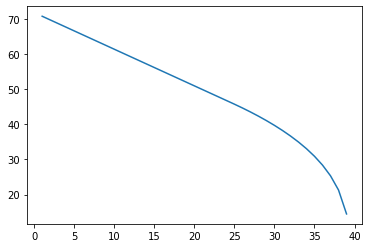

In [43]:
x_ok = x[:len(heights)]
plt.plot(x_ok , heights)
plt.show() # pour afficher.

# Conditions limites

In [44]:
binding_solution = Reagent(name = 'Binding solution',
                  flow_rate_aspirate = 0.5,
                  flow_rate_dispense = 0.5,
                  rinse = False,
                  delay = 1,
                  reagent_reservoir_volume = 10000, # 10 ml   
                  num_wells = 1,  # num_cols comes from available columns
                  h_cono = 46,
                  v_fondo = 46 * math.pi / 3  * (17.82/2) ** 2 ,  # (cone)
                           #    4 * math.pi * 4**3 / 3 (sphere)
                  rsup_cono = 17.82/2  # radius of the cone
                          )  # for a 

binding_solution.vol_well = 2000

In [45]:
get_height(binding_solution, aspirate_volume=0, min_height=0)

(37.061291066907586, False)

# Mesure réelle de la hauteur du liquide en fonction du volume

In [46]:
# Following is list of measures : (volume of liquid put in the vial, measured height in mm)
mesures = [   [0, 0]
            , [50, 5]
            , [100, 8]
            , [150, 10]
            , [200, 11.5]
            , [400, 16]
            , [600, 20]
            , [800, 22.5]    
            , [1000, 25.5]
            , [2000, 33.5]
            , [3000, 40]
            , [5000, 48.5]
            , [6000, 53]
            , [7000, 57.5]
            , [8000, 61.5]
           ]
# Ci-dessus, on lit que pour 2 ml, la hauteur de liquide est de 33.5 mm.

In [47]:
ul_lst, mm_lst =zip(*mesures)

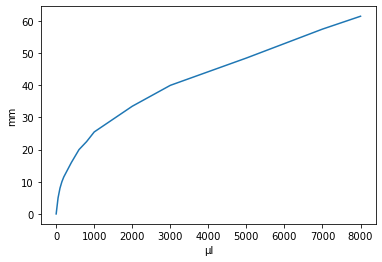

In [48]:
plt.plot(ul_lst, mm_lst)
plt.xlabel("µl")
plt.ylabel("mm")
plt.show()

# Ecart (fit) entre théorie et mesure

In [49]:
a_reagent = Reagent(name = 'Binding solution',
                  flow_rate_aspirate = 0.5,
                  flow_rate_dispense = 0.5,
                  rinse = False,
                  delay = 1,
                  reagent_reservoir_volume = 10000, # 10 ml   
                  num_wells = 1,  # num_cols comes from available columns
                  h_cono = 46,
                  v_fondo = 46 * math.pi / 3  * (17.82/2) ** 2 ,  # (cone)
                           #    4 * math.pi * 4**3 / 3 (sphere)
                  rsup_cono = 17.82/2  # radius of the cone
                          )  # for a 
    
def calcul_hauteur_theorique(reagent, volume):
    reagent.vol_well = volume
    h, _ = get_height(reagent, aspirate_volume=volume, min_height=0)
    return h

In [50]:
calcul_hauteur_theorique(a_reagent,2000)

37.061291066907586

In [51]:
theo = []
delta = []
for i, (vol, mesure_mm) in enumerate(mesures):
    th = calcul_hauteur_theorique(a_reagent, volume=vol)
    dlt = th - mesure_mm
    theo.append(th)
    delta.append(dlt)


Remaining volume: 0  Needed volume: 0
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 0.0

Remaining volume: 50  Needed volume: 50
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 10.836787248070781

Remaining volume: 100  Needed volume: 100
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 13.653496367076713

Remaining volume: 150  Needed volume: 150
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 15.629351752042886

Remaining volume: 200  Needed volume: 200
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 17.20232747754313

Remaining volume: 400  Needed volume: 400
Next column should be picked
Previous to change: 0
Next column should be picked
Prev

In [52]:
delta

[0.0,
 5.836787248070781,
 5.653496367076713,
 5.629351752042886,
 5.702327477543129,
 5.673574496141562,
 4.8100494127739,
 4.806992734153425,
 3.9155662134543654,
 3.561291066907586,
 2.4245877317036744,
 2.214374458123487,
 1.7239160164148544,
 1.2334575747062146,
 1.242999132997582]

In [53]:
for a in zip(ul_lst, theo, mm_lst, delta): 
    print ("\t".join(map(str, a)))

0	0.0	0	0.0
50	10.836787248070781	5	5.836787248070781
100	13.653496367076713	8	5.653496367076713
150	15.629351752042886	10	5.629351752042886
200	17.20232747754313	11.5	5.702327477543129
400	21.673574496141562	16	5.673574496141562
600	24.8100494127739	20	4.8100494127739
800	27.306992734153425	22.5	4.806992734153425
1000	29.415566213454365	25.5	3.9155662134543654
2000	37.061291066907586	33.5	3.561291066907586
3000	42.424587731703674	40	2.4245877317036744
5000	50.71437445812349	48.5	2.214374458123487
6000	54.723916016414854	53	1.7239160164148544
7000	58.733457574706215	57.5	1.2334575747062146
8000	62.74299913299758	61.5	1.242999132997582


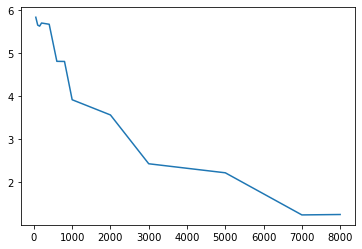

In [54]:
plt.plot(ul_lst[1:], delta[1:])
plt.show()

On va maintenant utiliser la courbe mesurée pour corriger l'équation théorique. Pour un volume donné, on cherche le volume mesuré juste au dessus et on retire la valeur de l'écart (et si on est en fin de liste, on retient la dernière corection)

In [56]:
def corrected_heigth(vol):
    th = calcul_hauteur_theorique(a_reagent, volume=vol)
    # Chercher le couple dont la première valeur est supérieure 
    AA = [ elt[0] for elt in mesures if elt[0]  < vol]
    position_of_correction = len(AA)
    if position_of_correction >= len(delta):
        position_of_correction -= 1
    return th - delta[position_of_correction]
    
corrected_heigth(10000)

69.51908311658273

# Application de la formule corrigée et confrontation aux mesures

In [57]:
corrected_heights = []
corrected_deltas = []
for i, (vol, mesure_mm) in enumerate(mesures):
    th = corrected_heigth(vol)
    dlt = th - mesure_mm
    corrected_heights.append(th)
    corrected_deltas.append(dlt)


Remaining volume: 0  Needed volume: 0
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 0.0

Remaining volume: 50  Needed volume: 50
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 10.836787248070781

Remaining volume: 100  Needed volume: 100
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 13.653496367076713

Remaining volume: 150  Needed volume: 150
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 15.629351752042886

Remaining volume: 200  Needed volume: 200
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 17.20232747754313

Remaining volume: 400  Needed volume: 400
Next column should be picked
Previous to change: 0
Next column should be picked
Prev

In [58]:
for a in zip(ul_lst, theo, mm_lst, delta, corrected_heights, corrected_deltas): 
    print ("\t".join(map(str, a)))

0	0.0	0	0.0	0.0	0.0
50	10.836787248070781	5	5.836787248070781	5.0	0.0
100	13.653496367076713	8	5.653496367076713	8.0	0.0
150	15.629351752042886	10	5.629351752042886	10.0	0.0
200	17.20232747754313	11.5	5.702327477543129	11.5	0.0
400	21.673574496141562	16	5.673574496141562	16.0	0.0
600	24.8100494127739	20	4.8100494127739	20.0	0.0
800	27.306992734153425	22.5	4.806992734153425	22.5	0.0
1000	29.415566213454365	25.5	3.9155662134543654	25.5	0.0
2000	37.061291066907586	33.5	3.561291066907586	33.5	0.0
3000	42.424587731703674	40	2.4245877317036744	40.0	0.0
5000	50.71437445812349	48.5	2.214374458123487	48.5	0.0
6000	54.723916016414854	53	1.7239160164148544	53.0	0.0
7000	58.733457574706215	57.5	1.2334575747062146	57.5	0.0
8000	62.74299913299758	61.5	1.242999132997582	61.5	0.0


# Maintenant, nous devons proposer une hauteur réelle de pipetage et un flag de changement de flacon

In [59]:
theo = []
delta = []
for i, (vol, mesure_mm) in enumerate(mesures):
    th = calcul_hauteur_theorique(a_reagent, volume=vol)
    dlt = th - mesure_mm
    theo.append(th)
    delta.append(dlt)


Remaining volume: 0  Needed volume: 0
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 0.0

Remaining volume: 50  Needed volume: 50
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 10.836787248070781

Remaining volume: 100  Needed volume: 100
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 13.653496367076713

Remaining volume: 150  Needed volume: 150
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 15.629351752042886

Remaining volume: 200  Needed volume: 200
Next column should be picked
Previous to change: 0
Next column should be picked
Previous to change: 0
Conical part
h 17.20232747754313

Remaining volume: 400  Needed volume: 400
Next column should be picked
Previous to change: 0
Next column should be picked
Prev

In [60]:
def get_pipetting_height(reagent, aspirate_volume, min_height=0.5, 
                         min_height_for_correction=0, z_offset = -2, measured_values=None, deltas=None):  
    """return the height as a positive value in mm where liquid will be pipetted
    this values is zeroed at the bottom of the vial.
    z_offset = (usually neg value in mm) : diminish height in order to secure pipetting.
    
    measured_values : (list of list)  : [[ml1, mm1]; [ml2, mm2]...]
        ml1 : volume 1 in microl put in the vial, 
        mm1 : height measure in mm
        ml2 : volume 2 in microl put in the vial, 
        mm2 : height measure in mm
    if measured_values and deltas are set, a corresponding value (delta) is substracted to improve the 
    theoretical value
    
    min_height_for_correction (mm) : below this value, there is no advantage to optimize pipetting height ; 
    so return min_height.
    """
    # géométrie du cone : 
    # hauteur max_du_cone
    # diamètre max d_ cone
    verbose = True if reagent.vol_well < 300 else False
    
    cone_height = reagent.h_cono
    cone_radius = reagent.rsup_cono
            
    if verbose : ctx.comment('\nRemaining volume: ' + str(reagent.vol_well) +
                '  Needed volume: ' + str(aspirate_volume));
        
    # Le puits est-il assez remplis pour fournir le volume demandé ?
    if reagent.vol_well > aspirate_volume:
        col_change = False
    else: 
        reagent.unused.append(reagent.vol_well)
        if verbose : 
            ctx.comment('Next column should be picked')
            ctx.comment('Previous to change: ' + str(reagent.col))
            ctx.comment('Next column should be picked')
            ctx.comment('Previous to change: ' + str(reagent.col))
        col_change = True
        
    # col_in_well = reagent.vol_well
    vol_at_end_of_pipetting = reagent.vol_well - aspirate_volume
    if verbose : print("vol_at_end_of_pipetting", vol_at_end_of_pipetting) ; 
    if (reagent.vol_well -  aspirate_volume) > reagent.v_cono :
        # we are in the top part
        if verbose: print("Cylinder part");
        sup_vol = vol_at_end_of_pipetting - reagent.v_cono
        if verbose : print("Volume in top part of container : ", sup_vol);
        theoretical_h = reagent.h_cono + (vol_at_end_of_pipetting - reagent.v_cono) / (cone_radius * cone_radius * math.pi)
        
    else:  
        if verbose: print("Conical part");
        # On est dans le cone
        theoretical_h = math.pow(3 * vol_at_end_of_pipetting
                     /(math.pi * cone_radius **2  / (cone_height ** 2)), 1/3)

    if verbose: print("theoretical_h", theoretical_h);
            
    # update reagent volume
    reagent.vol_well = reagent.vol_well - aspirate_volume

    h = theoretical_h
    
    # correction by a set of measures :     
    if measured_values and deltas:
        AA = [ measure[0] for measure in measured_values if measure[0]  < vol_at_end_of_pipetting]
        position_of_correction = len(AA)
        if position_of_correction >= len(delta):
           position_of_correction -= 1
        print("position_of_correction", position_of_correction)
        print("Valeur de correction", delta[position_of_correction])
        h = theoretical_h - delta[position_of_correction]
    
    if h < min_height_for_correction:
        h = 0
                
    if h < min_height:
         h = min_height
  
    return h, col_change

In [65]:
my_solution = Reagent(name = 'Binding solution',
                  flow_rate_aspirate = 0.5,
                  flow_rate_dispense = 0.5,
                  rinse = False,
                  delay = 1,
                  reagent_reservoir_volume = 10000, # 10 ml   
                  num_wells = 1,  # num_cols comes from available columns
                  h_cono = 46,
                  v_fondo = 46 * math.pi / 3  * (17.82/2) ** 2 ,  # (cone)
                           #    4 * math.pi * 4**3 / 3 (sphere)
                  rsup_cono = 17.82/2  # radius of the cone
                          )  # for a 

my_solution.vol_well = 8000
volume = 150

print(get_pipetting_height(my_solution, aspirate_volume=volume))
print()

get_pipetting_height(my_solution, aspirate_volume=volume, measured_values=mesures, 
                     deltas=delta, min_height_for_correction=10, min_height=0.5)

(62.14156789925387, False)

position_of_correction 14
Valeur de correction 1.242999132997582


(60.29713753251259, False)

# Use this method to optimize the distribution of binding soolution 

In [ ]:
nb_tests = 5

ctx.comment("**** Début distribution de binding solution")
p1000.distribute(260, binding_lysis_stock, reverse_order_wells(dest_plate, 8) [:nb_tests], disposal_volume=0, 
                 blowout_location = 'source well')

In [ ]:
reverse_order_wells(dest_plate, 8)[:nb_tests] 